Jupyter notebook for the analysis of phenotypic profiling data of BPA, BPS, PFOA, PFOS treated iCell WT mDA neurons (*Di Credico et al.*).

The notebook performs
- Loading data from two 384-well plates of a phenotypic profiling experiment (Plate 1 and Plate 2) present in a single .fth file
- Feature scaling per plate
- Plotting of individual features of choice to explore the data
- Unsupervised phenotypic profile analysis: 1) Plotting of phenotypic profiles as a Cosine distance-clustered heatmap, 2) UMAP and PaCMAP dimensionalty reduction for visualization
- Supervised phenotypic profile analysis: 1) Training of XGBoost and LightGBM classifiers on data from Plate 1, 2) Testing and quality metric plotting for both trained algorithms. 

To sucessfully run the notebook use the two provided raw_data.fth file and store it in the same root directory as the Jupyter Python Notebook.


#### Imports

In [25]:
# General packages for data loading and plotting
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from statannotations.Annotator import Annotator
# Packages for embeddings
import umap
import pacmap
# Packages for ML classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import joblib


#### Paths and data loading

In [26]:
# Input data (file should be located in root directory)
input_data = 'raw_data.fth'

# Saving locations (folders will be located in the root directory of the notebook)
saving_path = 'Results/'
saving_path_embedding = 'Results/Embedding/' 
saving_path_classif = 'Results/Classification/'

# Create the destination folders if they don't exist
if not os.path.exists(saving_path):
    os.makedirs(saving_path)

if not os.path.exists(saving_path_embedding):
    os.makedirs(saving_path_embedding)

if not os.path.exists(saving_path_classif):
    os.makedirs(saving_path_classif)

# Load data
df = pd.read_feather('raw_data.fth')

df_unscaled = df.copy()
df_unscaled.head()



#### Scale data per plate

In [27]:
# Define a function to standardize the numeric columns per category
def standardize_numeric(df):
    # Group the dataframe by the "Plate" column
    groups = df.groupby("Plate")
    # Loop through the groups and standardize the numeric columns
    for name, group in groups:
        print(group['Plate'].unique())
        numeric_cols = group.select_dtypes(include=["number"]).columns
        scaler = RobustScaler()
        group[numeric_cols] = scaler.fit_transform(group[numeric_cols])
        df.loc[group.index] = group
    return df

# Call the function to standardize the numeric columns per category
df_scaled = standardize_numeric(df)

# Save data as .csv
df_scaled.to_csv(saving_path + 'AllData_normalized.csv')

['Plate 1']
['Plate 2']


#### Compare data for randomly chosen feature before and after scaling

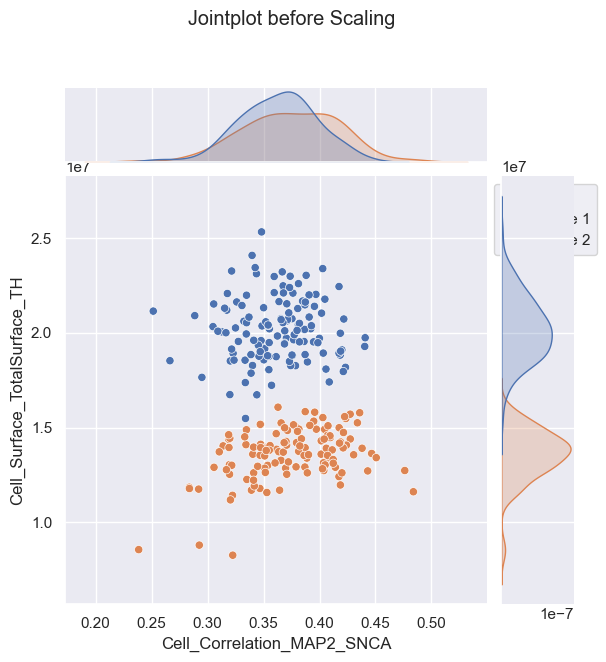

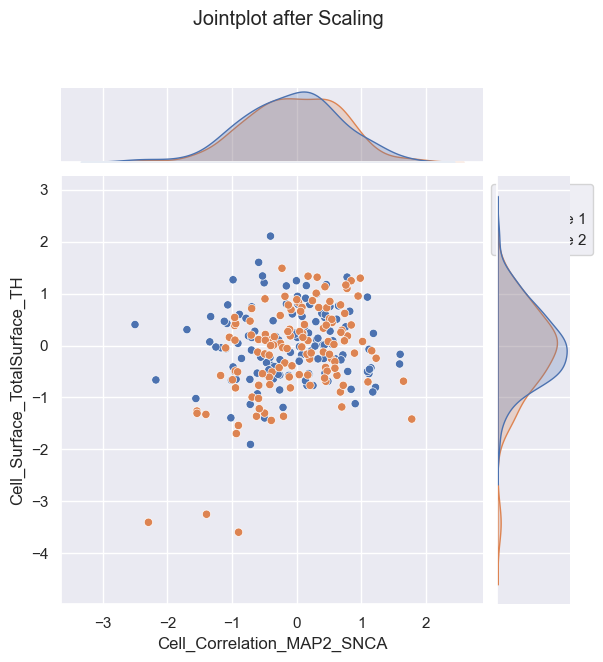

In [28]:
# Plot data before and after scaling
g = sns.jointplot(data=df_unscaled, 
              x="Cell_Correlation_MAP2_SNCA", 
              y="Cell_Surface_TotalSurface_TH", 
              hue='Plate')
plt.suptitle("Jointplot before Scaling", y=1.1)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1, 1))
plt.show()

g = sns.jointplot(data=df_scaled, 
              x="Cell_Correlation_MAP2_SNCA", 
              y="Cell_Surface_TotalSurface_TH", 
              hue='Plate')
plt.suptitle("Jointplot after Scaling", y=1.1)
sns.move_legend(g.ax_joint, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#### Data wrangling

In [29]:
# Update df to scaled data
df = df_scaled

# Extract compound and concentration in new columns
def extract_compound_concentration(row):
    tag = row['tags']
    if tag == 'Methanol CTRL BPA;iCell DPN AHN':
        return ('BPA', 0.001) # Compound is not present, but value is set to 0.001 to allow plotting on log axis
    elif tag == 'Methanol CTRL BPS;iCell DPN AHN':
        return ('BPS', 0.001) # Compound is not present, but value is set to 0.001 to allow plotting on log axis
    elif tag == 'Methanol CTRL PFOS;iCell DPN AHN':
        return ('PFOS', 0.001) # Compound is not present, but value is set to 0.001 to allow plotting on log axis
    elif tag == 'Methanol CTRL PFOA;iCell DPN AHN':
        return ('PFOA', 0.001) # Compound is not present, but value is set to 0.001 to allow plotting on log axis
    elif tag == 'iCell DPN AHN;no treat':
        return ('No methanol', 0.001) # Methanol is not present, but value is set to 0.001 to allow plotting on log axis
    else:
        compound, concentration = tag.split('#')
        concentration = concentration.replace('\uFFFD\uFFFD', 'µ').split(';')[0].replace('µ', '').replace('M', '')
        return (compound, concentration)

df[['Compound', 'Concentration']] = df.apply(extract_compound_concentration, axis=1, result_type='expand')
df['Condition'] = df['Compound'].astype(str) + ' ' + df['Concentration'].astype(str)

# Modify annotations
def manipulate_condition(x):
    if 'No methanol' in x:
        return 'Control'
    elif '0.001' in x:
        return 'Control'
    else:
        return x + ' uM'

df['Condition'] = df['Condition'].apply(manipulate_condition)

# Clean "Concentration" column
df['Concentration'] = df['Concentration'].astype(str).apply(lambda x: x.replace('μ', '')).astype(float)

# Drop colummns (contain no usable information)
cols_to_drop = ['IndividualCell_Intensity_RadialProfile_Minimum_SNCA', 'Nuclei_Living_Ratio_SNCA', 'Nuclei_Number_Big']
df_processed = df.drop(columns=cols_to_drop)

# Select data for feature plots
df_no_methanol = df_processed[df_processed['Compound'] != 'No methanol']

# Get counts
df_no_methanol.groupby('Condition').size()

Condition
BPA 0.01 uM     10
BPA 0.1 uM       9
BPA 1 uM         9
BPA 2 uM        10
BPS 0.01 uM     10
BPS 0.1 uM      10
BPS 1 uM         9
BPS 2 uM         9
Control         75
PFOA 0.01 uM     9
PFOA 0.1 uM     10
PFOA 1 uM        9
PFOA 2 uM        9
PFOS 0.01 uM     9
PFOS 0.1 uM     10
PFOS 1 uM        9
PFOS 2 uM        9
dtype: int64

#### Plotting of individual features

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_36220\1658679791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Concentration'] = data['Concentration'].astype(str)


    Well    Plate                              tags  \
0    D03  Plate 1                BPA#2  M;iCell DPN   
1    D04  Plate 1                BPA#2  M;iCell DPN   
2    D05  Plate 1                BPA#2  M;iCell DPN   
3    D06  Plate 1                BPA#2  M;iCell DPN   
4    D07  Plate 1                BPA#2  M;iCell DPN   
..   ...      ...                               ...   
230  I18  Plate 2  Methanol CTRL PFOA;iCell DPN AHN   
231  I19  Plate 2  Methanol CTRL PFOA;iCell DPN AHN   
232  I20  Plate 2  Methanol CTRL PFOA;iCell DPN AHN   
233  I21  Plate 2  Methanol CTRL PFOA;iCell DPN AHN   
234  I22  Plate 2  Methanol CTRL PFOA;iCell DPN AHN   

     Cell_Correlation_MAP2_SNCA  Cell_Correlation_TH_SNCA  \
0                     -0.748258                 -0.391425   
1                      0.024561                 -0.287775   
2                     -0.162330                  0.109126   
3                     -0.697750                  0.150129   
4                      0.146953   

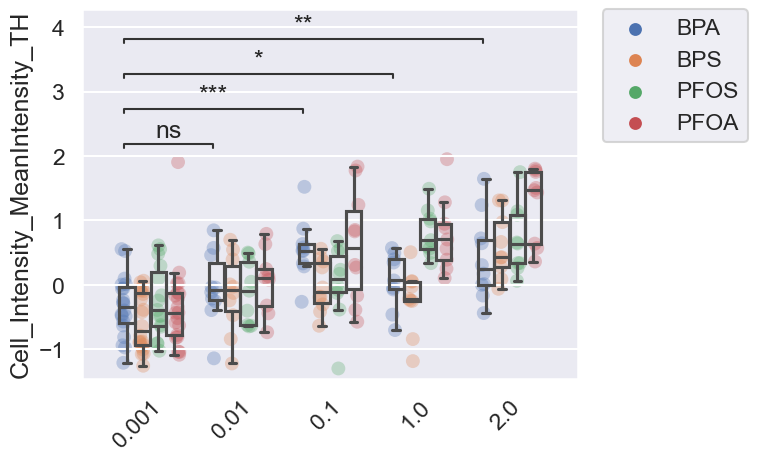

In [30]:
# What to plot?
data = df_no_methanol
data.to_csv(saving_path+"AllData_normed.csv")
data['Concentration'] = data['Concentration'].astype(str)
print(data)
y = 'Cell_Intensity_MeanIntensity_TH' # 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', Cell_Neurites_LengthPerNuclei_MAP2, Nuclei_Number_Living, Cell_Surface_TotalSurface_TH_SNCA
x = "Concentration"
hue = 'Compound'
hue_order = ['BPA', 'BPS', 'PFOS', 'PFOA']
order = ['0.001', '0.01', '0.1', '1.0', '2.0']
xtitle = 'Concentration (uM)'
ytitle = y
order = ['0.001', '0.01', '0.1', '1.0', '2.0']
stat_pairs=[(("0.001", "BPA"), ("0.01", "BPA")), 
            (("0.001", "BPA"), ("0.1", "BPA")), 
            (("0.001", "BPA"), ("1.0", "BPA")),
            (("0.001", "BPA"), ("2.0", "BPA")),
            #(("0.001", "BPS"), ("0.01", "BPS")), 
            #(("0.001", "BPS"), ("0.1", "BPS")), 
            #(("0.001", "BPS"), ("1.0", "BPS")),
            #(("0.001", "BPS"), ("2.0", "BPS")),
            #(("0.001", "PFOS"), ("0.01", "PFOS")), 
            #(("0.001", "PFOS"), ("0.1", "PFOS")), 
            #(("0.001", "PFOS"), ("1.0", "PFOS")),
            #(("0.001", "PFOS"), ("2.0", "PFOS")),
            #(("0.001", "PFOA"), ("0.01", "PFOA")), 
            #(("0.001", "PFOA"), ("0.1", "PFOA")), 
            #(("0.001", "PFOA"), ("1.0", "PFOA")),
            #(("0.001", "PFOA"), ("2.0", "PFOA")),
            ]

# Figure aesthetics
ax = sns.set_context("talk")
palette = sns.color_palette("tab10")

# Boxplot
ax = sns.boxplot(x=x, y=y, data=data, width=0.7, 
                         showfliers=False, hue=hue, order=order, zorder=1)
        
# Transparancy of boxplot filling color
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))

# Stripplot overlaying boxplot
ax = sns.stripplot(x=x, y=y, data=data, size=10, alpha=0.3, 
                           zorder=0, hue=hue, order=order, dodge=True)
        
# Figure aesthetics
# Remove first rows from legend and move it
h,l = ax.get_legend_handles_labels()
plt.legend(h[4:8],l[4:8],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Axis labels
ax.set(xlabel=None)
ax.set(ylabel=y)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right', 
                           rotation_mode="anchor")

# Add statistical annotations
annotator = Annotator(ax, stat_pairs, data=data, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annotator.configure(test='t-test_welch', text_format='star', loc='inside')
annotator.apply_and_annotate()

plt.show()

#### Plotting of individual features as dose-response curve (DRC)

C:\Users\JohannesWilbertz\AppData\Local\Temp\ipykernel_36220\3599593496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Concentration'] = data['Concentration'].astype(float)


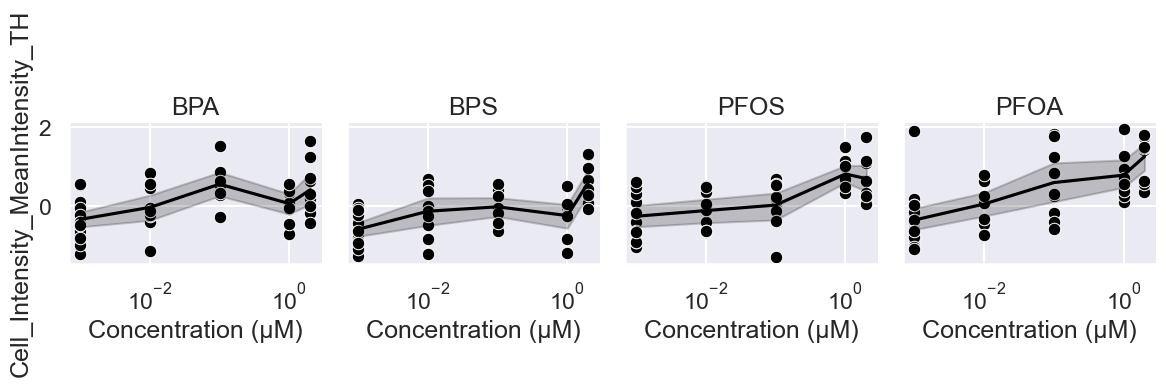

In [31]:
# What to plot?
data = df_no_methanol
data['Concentration'] = data['Concentration'].astype(float)
y = y # 'Cell_TH_SNCA_Intensity_SumIntensityPerNuclei_SNCA', Cell_Neurites_LengthPerNuclei_MAP2, Nuclei_Number_Living, Membrane_Intensity_MeanIntensity_TH, Cell_Neurites_BranchingPointsPerNuclei_MAP2
x = "Concentration"
plot_col = 'Compound'
xtitle = 'Concentration (uM)'
ytitle = y

# Set up facet grid to plot all compound DRCs per feature in one plot
grid = sns.FacetGrid(data, col=plot_col, col_wrap=4, aspect=1)

# Draw line plots
grid.map(sns.scatterplot, x, y, color='black')
grid.map(sns.lineplot, x, y, color='black')

# Adjust the scale & ticks
grid.set(xscale="log")
grid.set(ylim=(None, None))
# Adjust titles
grid.set_titles("{col_name}", size=18)
# Adjust axis labels
grid.set_axis_labels(x_var="Concentration (μM)", y_var=ytitle)

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

# Save plot
plt.savefig(saving_path + y + '.pdf', bbox_inches='tight')
plt.show()

#### Plotting of all features as dose-response curve (DRC)

In [32]:
# Plot all features as DRCs: yes or no?
plot_all_features_DRC = 'no'

if plot_all_features_DRC == 'yes':
    df_numeric = data.select_dtypes(np.number)
    df_numeric = df_numeric.drop(columns=['Concentration'])
    for col in df_numeric.columns:  
        
        # Set up facet grid to plot all compound DRCs per feature in one plot
        grid = sns.FacetGrid(data, col=plot_col, col_wrap=2, aspect=1)
    
        # Draw line plots
        grid.map(sns.scatterplot, x, col, color='black')
        grid.map(sns.lineplot, x, col, color='black')
    
        # Adjust the scale & ticks
        grid.set(xscale="log")
        grid.set(ylim=(None, None))
        # Adjust titles
        grid.set_titles("{col_name}", size=18)
        # Adjust axis labels
        grid.set_axis_labels(x_var="Concentration (μM)", y_var=col)
    
        # Adjust the arrangement of the plots
        grid.fig.tight_layout(w_pad=1)
        
        # Save plot
        plt.savefig(saving_path + col + '_DRC.png', bbox_inches='tight')
        plt.close()

#### Display of dataset as phenotypic profile using a clustered heatmap

Preparation of data for cluster-heatmap plotting

In [33]:
# Used data
data = df_processed

# Select only the numeric columns and the 'Condition' column
numeric_cols = data.select_dtypes(include=np.number).columns.tolist() + ['Condition']

# Drop all non-numeric columns except 'Condition' column
data_num = data[numeric_cols]

# Drop a number of not required columns
cols_to_drop = ['Concentration']
data_num = data_num.drop(cols_to_drop, axis=1)

# Group rows based on "Condition" column and calculate median
data_num_med = data_num.groupby(['Condition'], as_index=False).median()

# Change column names for ordered plotting of columns per category in the following plot

# First round of adding prefixes
data_num_med.columns = ['context_' + col if 'Correlation' in col else col for col in data_num_med.columns]
data_num_med.columns = ['intensity_' + col if 'Intensity' in col else col for col in data_num_med.columns]
data_num_med.columns = ['shape_' + col if 'Neurites' in col else col for col in data_num_med.columns]
data_num_med.columns = ['shape_' + col if 'Surface' in col else col for col in data_num_med.columns]
data_num_med.columns = ['texture_' + col if 'Texture' in col else col for col in data_num_med.columns]
data_num_med.columns = ['context_' + col if '_Ratio_' in col else col for col in data_num_med.columns]
data_num_med.columns = ['context_' + col if '_Number_' in col else col for col in data_num_med.columns]

# Second round of adding prefixes
for i, col in enumerate(data_num_med.columns):
    if 'Cell_' in col:
        data_num_med.columns.values[i] = 'Cell_' + col
    elif 'Cytoplasm_' in col:
        data_num_med.columns.values[i] = 'Cytoplasm_' + col
    elif 'Membrane_' in col:
        data_num_med.columns.values[i] = 'Membrane_' + col
    elif 'Nuclei_' in col:
        data_num_med.columns.values[i] = 'Nucleus_' + col

# Sort columns alphabetically
data_num_med = data_num_med.sort_index(axis=1)

# Get column names
col_names = data_num_med.columns.values.tolist()

Clustered heatmap representation of all compound and control phenotypic profiles

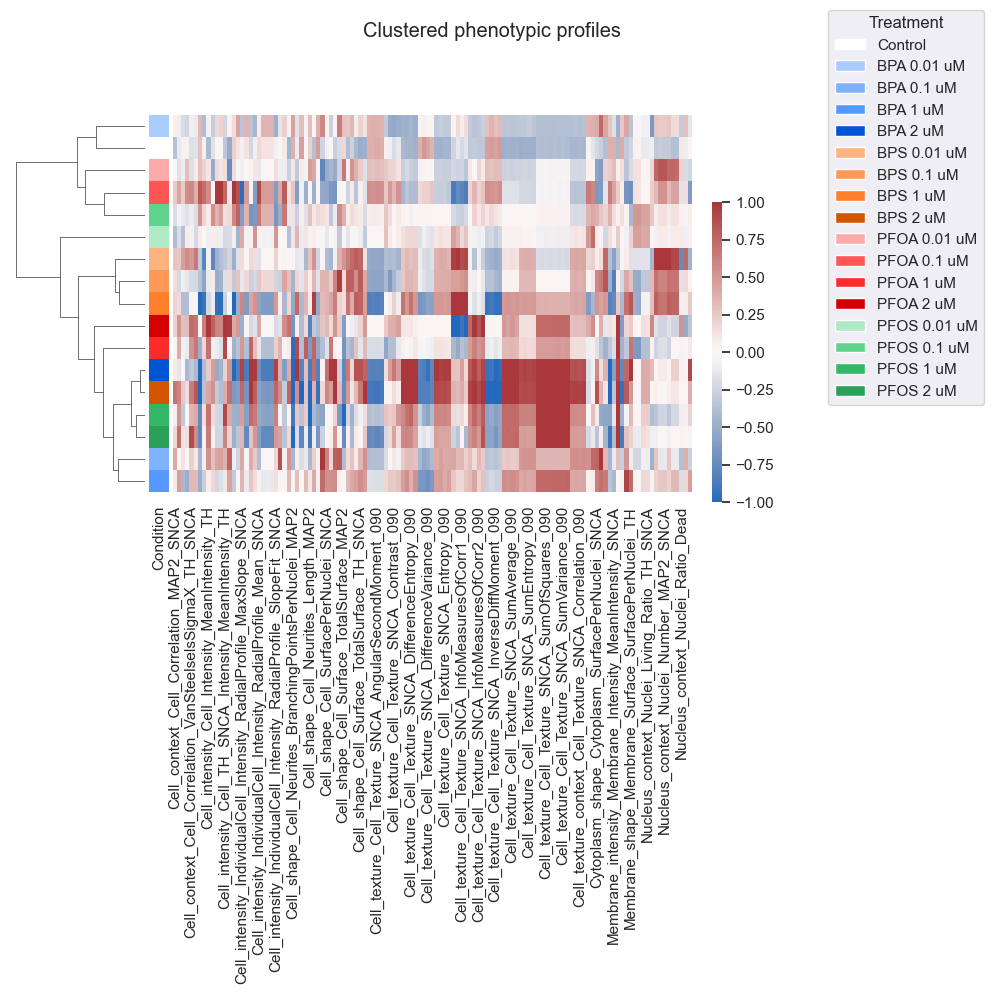

In [34]:
lut = {'Control': 'white',
       'BPA 0.01 uM': '#aaccffff',
       'BPA 0.1 uM': '#80b3ffff',
       'BPA 1 uM': '#5599ffff',
       'BPA 2 uM': '#0055d4ff',
       'BPS 0.01 uM': '#ffb380ff',
       'BPS 0.1 uM': '#ff9955ff',
       'BPS 1 uM': '#ff7f2aff',
       'BPS 2 uM': '#d45500ff',
       'PFOA 0.01 uM': '#ffaaaaff',
       'PFOA 0.1 uM': '#ff5555ff',
       'PFOA 1 uM': '#ff2a2aff',
       'PFOA 2 uM': '#d40000ff',
       'PFOS 0.01 uM': '#afe9c6ff',
       'PFOS 0.1 uM': '#5fd38dff',
       'PFOS 1 uM': '#32b867ff',
       'PFOS 2 uM': '#2ca05aff'}

row_colors = data_num_med['Condition'].map(lut)

data_num_med2 = data_num_med.drop(columns = ['Condition'])

# Plot clustermap
sns.set_context('paper')
sns.set(font='Arial')
g = sns.clustermap(data_num_med2,
                   metric='cosine',
                   col_cluster=False,
                   cmap = "vlag",
                   row_colors = row_colors,
                   yticklabels=False,
                   vmin=-1, vmax=1)

# Move and adjust legend
g.fig.subplots_adjust(right=0.7)
g.ax_cbar.set_position((0.72, .5, .01, .3))
g.fig.suptitle('Clustered phenotypic profiles')
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Treatment',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

# Save plot
plt.savefig(saving_path + 'PhenoProfile_ClusterMap_All_Compounds' + '.pdf', bbox_inches='tight')
plt.show()

#### Dimension reduction for easier dataset visualization

Preparation of data for dimension reduction

In [35]:
# Select data for following plots
df_embedding = df_processed[(df_processed['Concentration'] == 0.001) | (df_processed['Concentration'] == 2)]
n_conditions = len(df_embedding['Condition'].unique())

# Standard scale numeric data
df_numeric = df_embedding.select_dtypes(np.number)
df_numeric = df_numeric.drop(columns=['Concentration'])
#drug_data = df_numeric.values
#scaled_drug_data = StandardScaler().fit_transform(drug_data)

UMAP dimension reduction

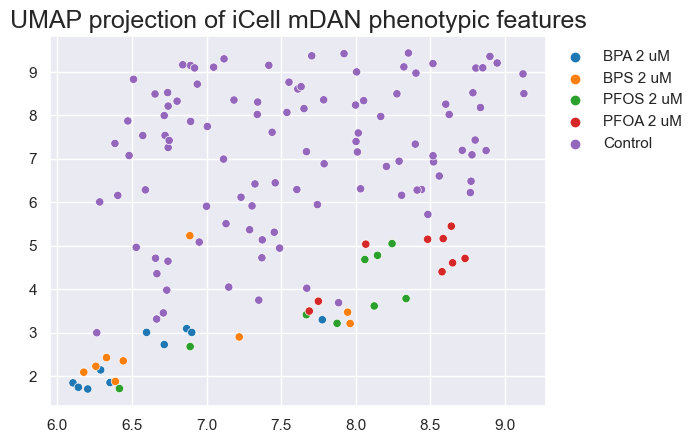

In [36]:
# Initializing the UMAP instance
reduce_umap = umap.UMAP()

# Train the reducer to create embedding
embedding_umap = reduce_umap.fit_transform(df_numeric)

# Plot embedding as scatterplot
ax = sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=df_embedding.Condition,
    palette=sns.color_palette("tab10", n_colors=n_conditions))

plt.title('UMAP projection of iCell mDAN phenotypic features', fontsize=18)

leg = ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(saving_path_embedding + 'UMAP' + '.pdf', bbox_inches='tight')
plt.show()

PaCMAP dimension reduction

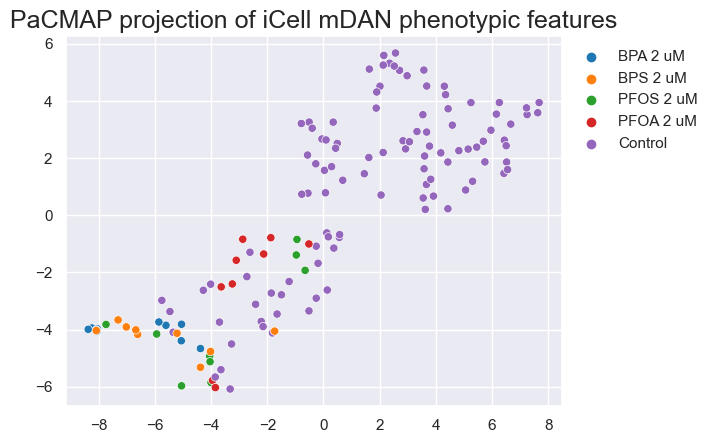

In [37]:
# Initializing the PaCMAP instance
reducer_pacmap = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.5) 

# Train the reducer to create embedding
embedding_pacmap = reducer_pacmap.fit_transform(df_numeric, init="random")

# Plot embedding as scatterplot
ax = sns.scatterplot(
    x=embedding_pacmap[:, 0],
    y=embedding_pacmap[:, 1],
    hue=df_embedding.Condition,
    palette=sns.color_palette("tab10", n_colors=n_conditions))

plt.title('PaCMAP projection of iCell mDAN phenotypic features', fontsize=18)

leg = ax.legend(frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(saving_path_embedding + 'PaCMAP' + '.pdf', bbox_inches='tight')
plt.show()

#### ML classification

Preparation of data for classification

In [38]:
# Drop colummns
cols_to_drop = ['Concentration', 'IndividualCell_Intensity_RadialProfile_Minimum_SNCA',
                'Nuclei_Living_Ratio_SNCA', 'Nuclei_Number_Big']
df_classif = df.drop(columns=cols_to_drop)

# OPTIONAL: Exclude columns of a certain feature type i.e. "Texture"
#df_classif = df_classif.filter(regex='^(?!.*Texture)')
#df_classif = df_classif.filter(regex='^(?!.*Total)')

# Create a binary target column for whether the condition is "Control" or not
df_classif['Control'] = (df_classif['Condition'] == 'Control').astype(int)

# Split the data into features and target
X = df_classif.drop(columns=['Control']).select_dtypes(include=[np.number])
y = df_classif['Control']

Train the XGBoost classifier and use GridSearchCV to find hyperparamters

Best Hyperparameters: {'classifier__max_depth': 1, 'classifier__n_estimators': 50}


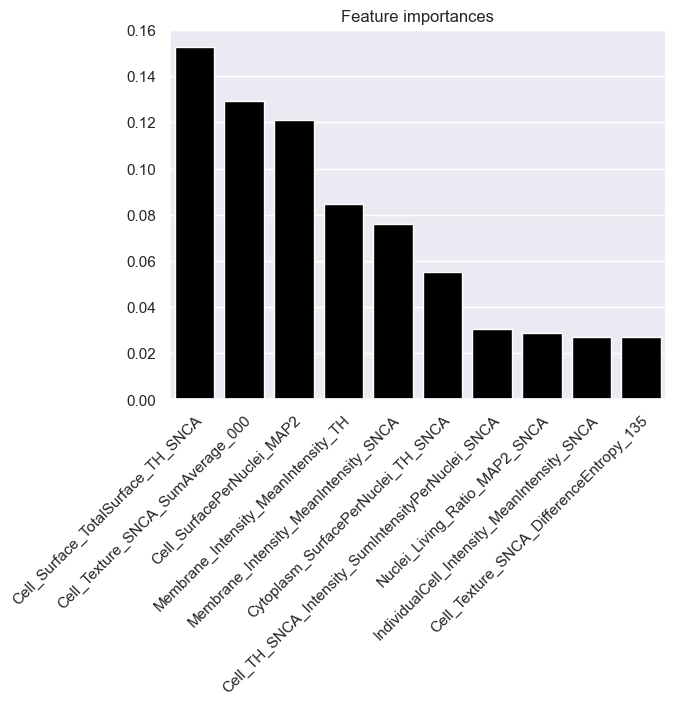

In [39]:
# Create the pipeline for preprocessing and classification
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier())  #('scaler', StandardScaler()),
])

# Define the hyperparameter search space
param_grid = {'classifier__n_estimators': [1, 2, 5, 10, 50, 100, 200],
              'classifier__max_depth': [1, 2, 3, 5, 10, 20]}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=42, stratify=y)

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the pipeline on the full training set with the best hyperparameters
pipeline.set_params(**grid_search.best_params_)
pipeline.fit(X_train, y_train)

# Save the pipeline 
joblib.dump(pipeline, saving_path_classif + 'XGBoost_classifier_pipeline.joblib')

# Get and plot feature importances
def plot_feature_importances(model, feature_names, top_n):
    model = model.named_steps["classifier"]

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure()
    sns.barplot(x=feature_names[indices], y=importances[indices], color="black")
    plt.title("Feature importances")
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.savefig(saving_path_classif + 'FeatureImportances_XGBoost.pdf', bbox_inches='tight')
    plt.show()

plot_feature_importances(pipeline, X.columns, top_n=10)

Evaluate trained XGBoost classifier on test set

        Condition  True Control  Pred Control  Control Prob
102       Control             1             1      0.982684
71   PFOS 0.01 uM             0             1      0.631201
153      BPS 1 uM             0             0      0.137343
199  PFOA 0.01 uM             0             0      0.241035
14      PFOS 2 uM             0             0      0.015543
171    BPS 0.1 uM             0             0      0.403654
180   PFOA 0.1 uM             0             1      0.900818
220       Control             1             1      0.590090
152      BPS 1 uM             0             0      0.196982
137      BPS 2 uM             0             0      0.031082
108       Control             1             1      0.808182
20       BPA 1 uM             0             0      0.028640
111       Control             1             1      0.880746
122       Control             1             0      0.424915
94        Control             1             1      0.907728
252       Control             1         

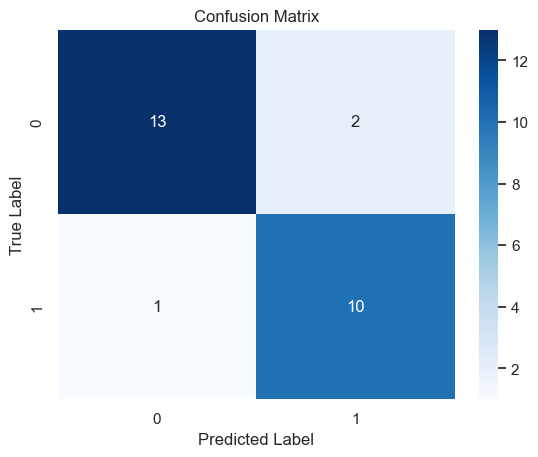

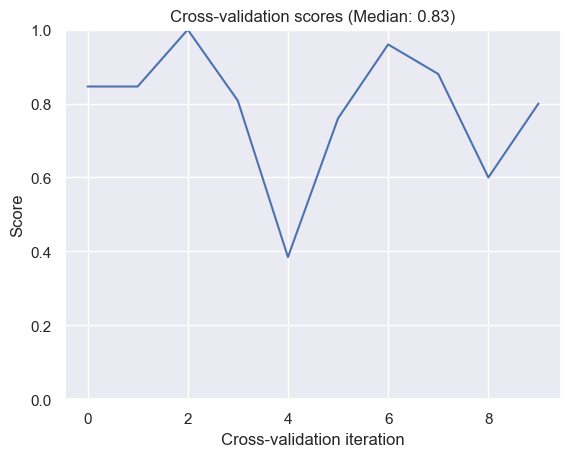

In [40]:
# Make predictions on the test set and get the probabilities of each sample belonging to the "Control" class
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Add the true condition labels to the results for comparison
results = pd.DataFrame({'Condition': df.loc[X_test.index, 'Condition'],
                        'True Control': y_test,
                        'Pred Control': y_pred,
                        'Control Prob': y_probs})
print(results)

# Save results as table
results.to_csv(saving_path_classif + 'Test_set_classification_XGBoost.csv')

# Evaluate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(saving_path_classif + 'Confusion_Matrix_XGBoost.pdf', bbox_inches='tight')
plt.show()

# Plot the cross-validation scores accross the whole dataset
scores = cross_val_score(pipeline, X, y, cv=10)
sns.lineplot(data=scores)
plt.xlabel("Cross-validation iteration")
plt.ylabel("Score")
plt.ylim(0, 1)
median_score = np.median(scores)
plt.title(f"Cross-validation scores (Median: {median_score:.2f})")
plt.savefig(saving_path_classif + 'CV_scores_XGBoost.pdf', bbox_inches='tight')
plt.show()

Train the LightGBM classifier and use GridSearchCV to find hyperparamters

In [41]:
# Create the pipeline for preprocessing and classification
pipeline_LightGBM = Pipeline([
    ('classifier', lgb.LGBMClassifier())
    ])

# Define the hyperparameter search space
param_grid = {'classifier__num_leaves': [2, 3, 10, 20],
              'classifier__max_depth': [1, 2, 3, 5, 7, 9, 11],
              'classifier__learning_rate': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
              'classifier__colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.9, 1.0]
              }

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=42, stratify=y)

# Use grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(pipeline_LightGBM, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the pipeline on the full training set with the best hyperparameters
pipeline_LightGBM.set_params(**grid_search.best_params_)
pipeline_LightGBM.fit(X_train, y_train)

# Save the pipeline 
joblib.dump(pipeline, saving_path_classif + 'LightGBM_classifier_pipeline.joblib')

# Get and plot feature importances
def plot_feature_importances(model, feature_names, top_n):
    model = model.named_steps["classifier"]

    importances = model.booster_.feature_importance()
    importances_percent = importances / np.sum(importances)
    indices = np.argsort(importances)[::-1][:top_n]
    sns.barplot(x=feature_names[indices], y=importances_percent[indices], color="black")
    plt.title("Feature importances")
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.savefig(saving_path_classif + 'FeatureImportances_LightGBM' + '.pdf', bbox_inches='tight')
    plt.show()

plot_feature_importances(pipeline_LightGBM, X.columns, top_n=10)

Evaluate trained LightGBM classifier on test set

        Condition  True Control  Pred Control  Control Prob
102       Control             1             1  9.999915e-01
71   PFOS 0.01 uM             0             0  5.368205e-02
155      BPS 1 uM             0             0  1.738388e-03
203  PFOA 0.01 uM             0             0  4.614008e-01
14      PFOS 2 uM             0             0  2.358374e-06
174    BPS 0.1 uM             0             0  3.685985e-02
183   PFOA 0.1 uM             0             1  9.884625e-01
225       Control             1             1  8.117845e-01
154      BPS 1 uM             0             0  3.337603e-02
137      BPS 2 uM             0             0  6.913981e-06
108       Control             1             1  9.981855e-01
20       BPA 1 uM             0             0  2.666782e-06
111       Control             1             1  8.579807e-01
122       Control             1             1  9.747371e-01
94        Control             1             1  9.994802e-01
259       Control             1         

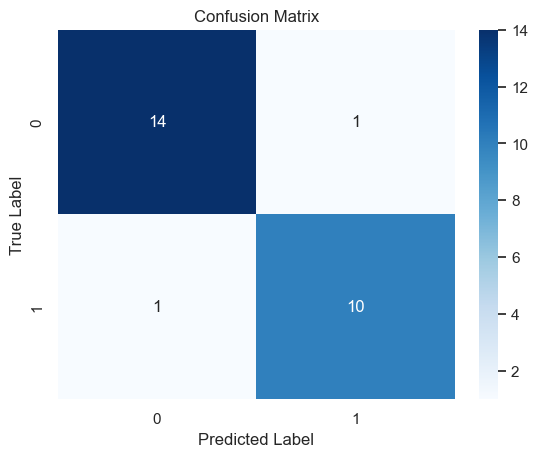

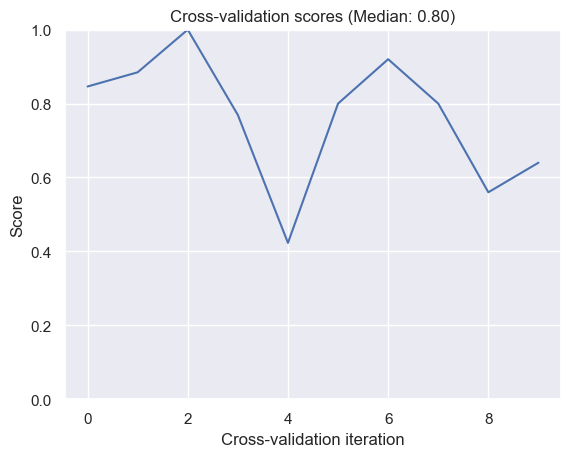

In [ ]:
# Make predictions on the test set and get the probabilities of each sample belonging to the "Control" class
y_pred = pipeline_LightGBM.predict(X_test)
y_probs = pipeline_LightGBM.predict_proba(X_test)[:, 1]

# Add the true condition labels to the results for comparison
results = pd.DataFrame({'Condition': df.loc[X_test.index, 'Condition'],
                        'True Control': y_test,
                        'Pred Control': y_pred,
                        'Control Prob': y_probs})
print(results)

# Save results as table
results.to_csv(saving_path_classif + 'Test_set_classification_LightGBM.csv')

# Evaluate the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(saving_path_classif + 'Confusion_Matrix_LightGBM.pdf', bbox_inches='tight')
plt.show()

# Plot the cross-validation scores accross the whole dataset
scores = cross_val_score(pipeline_LightGBM, X, y, cv=10)
sns.lineplot(data=scores)
plt.xlabel("Cross-validation iteration")
plt.ylabel("Score")
plt.ylim(0, 1)
median_score = np.median(scores)
plt.title(f"Cross-validation scores (Median: {median_score:.2f})")
plt.savefig(saving_path_classif + 'CV_scores_LightGBM.pdf', bbox_inches='tight')
plt.show()